<a href="https://colab.research.google.com/github/LeoVogiatzis/medical_data_analysis/blob/main/Class_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install tensorflow-gpu
!pip install gdown

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

from google.colab import files
uploaded = files.upload()

Saving Thyroid_Sick_fixed.csv to Thyroid_Sick_fixed (10).csv


In [ ]:
import io

data = pd.read_csv(io.BytesIO(uploaded['Thyroid_Sick_fixed.csv']))

In [ ]:
data

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,Class
0,41.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.30,t,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,23.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.10,t,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other,negative
2,46.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
3,70.0,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
4,70.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,F,f,f,f,f,f,f,f,f,f,f,f,t,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,negative
3768,68.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.00,t,2.1,t,124.0,t,1.08,t,114.0,f,NaN,SVI,negative
3769,74.0,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,t,5.10,t,1.8,t,112.0,t,1.07,t,105.0,f,NaN,other,negative
3770,72.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.70,t,2.0,t,82.0,t,0.94,t,87.0,f,NaN,SVI,negative


In [ ]:
def percentage(part, whole):
  return 100 * float(part) / float(whole)

In [ ]:
negative, sick = data['Class'].value_counts()
print(f'No claim {negative}')
print(f'Claim {sick}')
print(f'Claim proportion {round(percentage(sick, sick + negative), 2)}%')

No claim 3541
Claim 231
Claim proportion 6.12%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


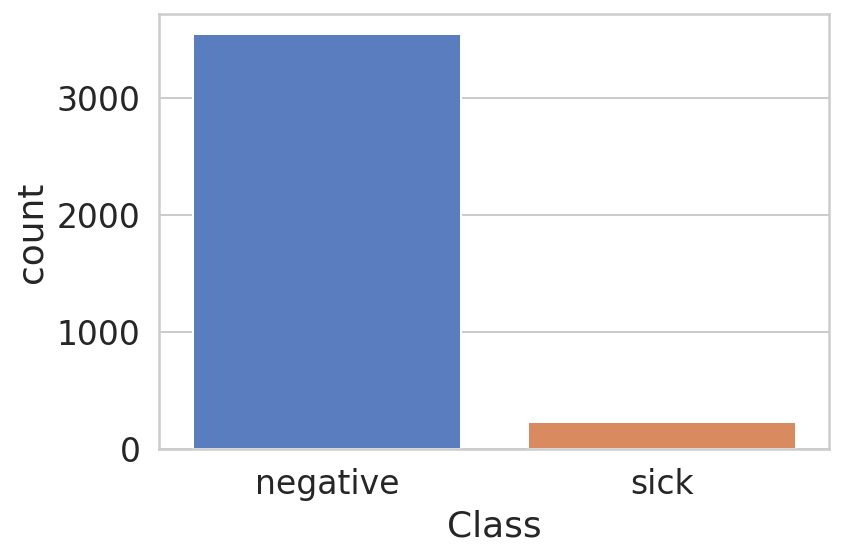

In [ ]:
import seaborn as sns
sns.countplot(data['Class'])

In [ ]:
print(data.isnull().sum())



age                             1
sex                           150
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH measured                    0
TSH                           369
T3 measured                     0
T3                            769
TT4 measured                    0
TT4                           231
T4U measured                    0
T4U                           387
FTI measured                    0
FTI                           385
TBG measured                    0
TBG                          3772
referral source                 0
Class         

In [ ]:
data.drop(["TBG", "referral source"], axis=1, inplace=True)
data = data.loc[:, ~data.columns.str.endswith("measured")]

In [ ]:
data.dropna(subset=['sex'], inplace=True)

data = data.replace(["f", "t"], [0, 1])
data = data.replace(["F", "M"], [0, 1])
data = data.replace(["negative", "sick"], [0, 1])

#cat_columns = ['sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid',
              # 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych','Class']
#num_columns = ['TSH', 'T3', 'TT4','T4U', 'FTI']



#Class = {'N': 1,'female': 0}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
print(data.shape)
data

(3622, 22)


,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,Class
0,41.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.30,2.5,125.0,1.14,109.0,0
1,23.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.10,2.0,102.0,NaN,NaN,0
2,46.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.98,NaN,109.0,0.91,120.0,0
3,70.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.16,1.9,175.0,NaN,NaN,0
4,70.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.72,1.2,61.0,0.87,70.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,0
3768,68.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,2.1,124.0,1.08,114.0,0
3769,74.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5.10,1.8,112.0,1.07,105.0,0
3770,72.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.70,2.0,82.0,0.94,87.0,0


##Missing values - Simple model

In [ ]:
X = data.drop(columns=['Class'])
y = data['Class']

In [ ]:
from sklearn import model_selection, metrics
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights="uniform")
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
x_test.shape

(1087, 21)

In [ ]:
y_train.shape

(2535,)

## Neural Network

In [ ]:
def build_model(train_data, metrics=["accuracy"]):
  model = keras.Sequential([
    keras.layers.Dense(
      units=36, 
      activation='relu',
      input_shape=(train_data.shape[-1],)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(units=1, activation='sigmoid'),
  ])

  model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
  )

  return model

In [ ]:
model = build_model(x_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
BATCH_SIZE = 2048
model = build_model(x_train)
history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.05,
    shuffle=True,
    verbose=0
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#import matplotlib as plt

def plot_accuracy(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
            label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
            label = 'Val Accuracy')
  plt.ylim((0, 1))
  plt.legend()
  plt.show()

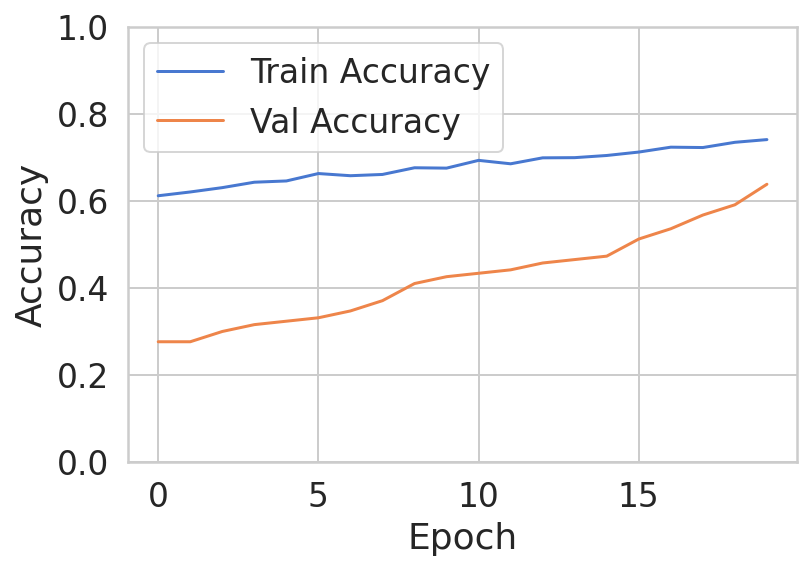

In [ ]:
plot_accuracy(history)

In [ ]:
model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

1/1 [==============================] - 0s 20ms/step - loss: 0.6940 - accuracy: 0.5998


[0.69399493932724, 0.5998160243034363]

## Dummy model

In [ ]:
def awesome_model_predict(features):
  return np.full((features.shape[0], ), 0)
y_pred = awesome_model_predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.9365225390984361

## Evaluation - Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):

  tick_labels = ['Negative', 'Sick']

  cm = confusion_matrix(labels, predictions > p)
  ax = sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

In [ ]:
model_pred = model.predict(x_test, batch_size=BATCH_SIZE)

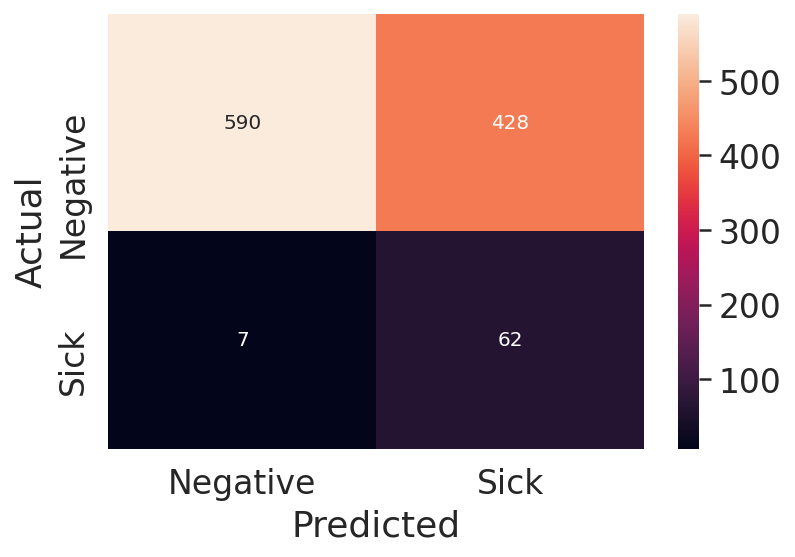

In [ ]:
plot_cm(y_test, model_pred)

## More metrics

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [ ]:
from sklearn.metrics import f1_score

def print_metrics(model, evaluation_results, predictions):
  for name, value in zip(model.metrics_names, evaluation_results):
    print(name, ': ', value)
  print(f'f1 score: {f1_score(y_test, np.round(y_pred.flatten()))}')
  print()

In [ ]:
model = build_model(x_train, metrics=METRICS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.05, 
    shuffle=True,
    verbose=0
)

In [ ]:
evaluation_results = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model.predict(x_test, batch_size=BATCH_SIZE)
print_metrics(model, evaluation_results, y_pred)

loss :  0.6346036195755005
tp :  63.0
fp :  335.0
tn :  683.0
fn :  6.0
accuracy :  0.6862925291061401
precision :  0.15829145908355713
recall :  0.9130434989929199
auc :  0.9017895460128784
f1 score: 0.2698072805139186



## ROC curve

In [ ]:
from sklearn.metrics import roc_curve

def plot_roc(labels, predictions):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(fp, tp, label='ROC', linewidth=3)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.plot(
      [0, 1], [0, 1], 
      linestyle='--', 
      linewidth=2, 
      color='r',
      label='Chance', 
      alpha=.8
  )
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  plt.legend(loc="lower right")

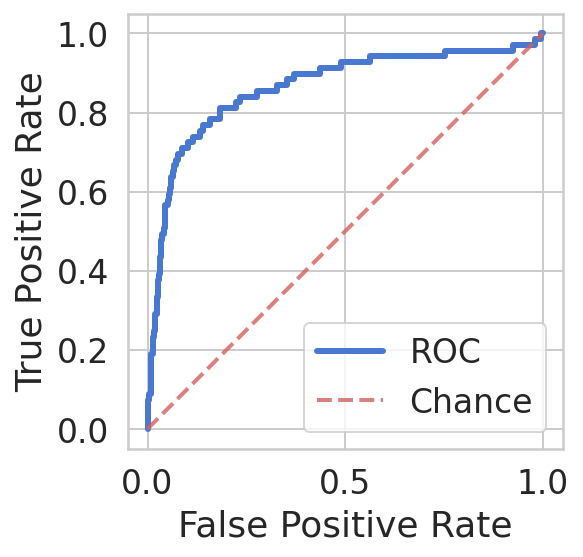

In [ ]:
plot_roc(y_test, model_pred)

## Weighted model

In [ ]:
negative_count, sick_count = np.bincount(data['Class'])
total_count = len(data['Class'])

In [ ]:
weight_negative = (1 / negative_count) * (total_count) / 2.0 
weight_sick = (1 / sick_count) * (total_count) / 2.0 


class_weights = {0: weight_negative, 1: weight_sick}

class_weights

{0: 0.5331174565793347, 1: 8.04888888888889}

In [ ]:
model = build_model(x_train, metrics=METRICS)

history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.05, 
    shuffle=True,
    verbose=0,
    class_weight=class_weights
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model_pred = model.predict(x_test, batch_size=BATCH_SIZE)

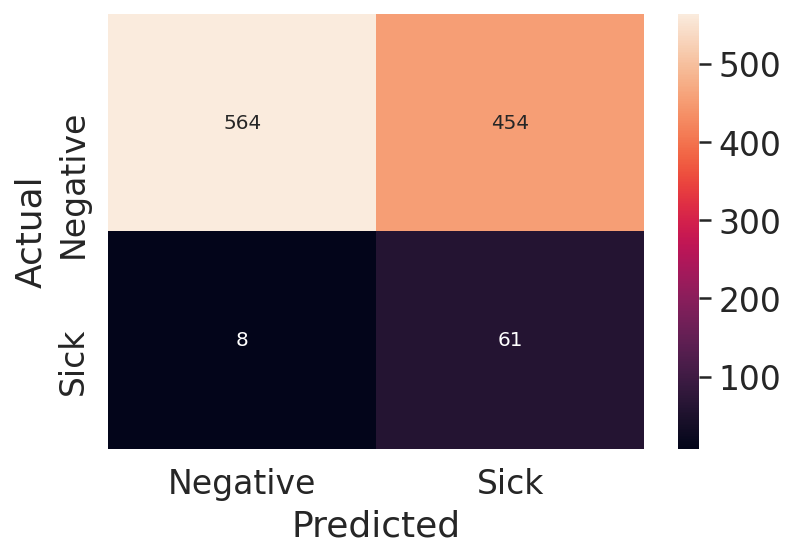

In [ ]:
plot_cm(y_test, model_pred)

In [ ]:
evaluation_results = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model.predict(x_test, batch_size=BATCH_SIZE)
print_metrics(model, evaluation_results, y_pred)

loss :  0.6716082692146301
tp :  61.0
fp :  454.0
tn :  564.0
fn :  8.0
accuracy :  0.5749769806861877
precision :  0.11844660341739655
recall :  0.8840579986572266
auc :  0.8369707465171814
f1 score: 0.20890410958904113



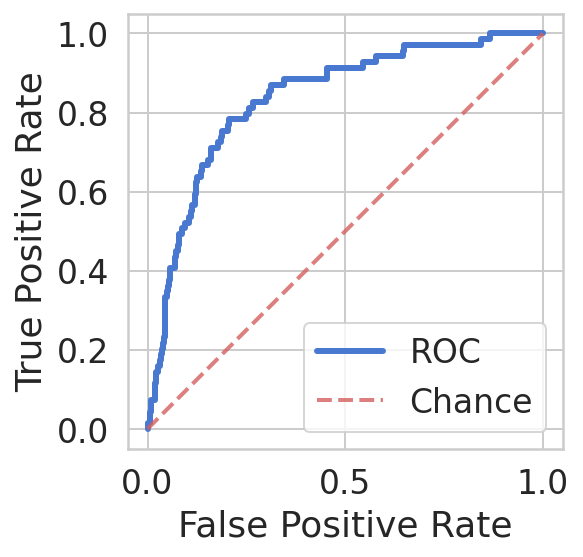

In [ ]:
plot_roc(y_test, model_pred)